# **[Chapter 02]**  
**┗ 당뇨 환자 병원 재방문 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「Error analysis」
* 🥇Session 3 - 「주제그룹 분석」

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
# from google.colab import drive
# drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/인공지능/ML_Project_Collection/당뇨환재재입원예측")
os.getcwd()



'/content/drive/MyDrive/인공지능/ML_Project_Collection/당뇨환재재입원예측'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🏭

```
당뇨병은 세계 성인 인구의 9% 이상에 영향을 미치고 있으며, 점점 더 증가하고 있다.
당뇨 환자는 지속적인 관찰과 치료가 필요하며, 중증 환자는 더 세심한 관리가 필요하다.
일단, 우리의 목적은 30일 이내에 재입원해야 하는 환자를 예측하는 모델을 생성하는 것이다.
병원에서 중증 환자의 모니터링, 조기 예약, 간호사 호출과 같은 예방 조치를 더 많이 취할 수 있다고 생각해보자.
이는, 많은 생명을 구할 수 있는 일이 될지도 모른다.
우리는 당뇨 환자의 재입원을 예측하는 모델을 만들어보고, 모델의 성능 향상을 위해 에러의 분포를 분석하여 성능을 향상시켜보자.
```



In [2]:
# openml API를 사용하여 당뇨 환자 데이터 읽어오기
from sklearn.datasets import fetch_openml
X_orig, y = fetch_openml(data_id=43874, as_frame=True, return_X_y=True)

In [3]:
X_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  object  
 3   discharge_disposition_id  101766 non-null  object  
 4   admission_source_id       101766 non-null  object  
 5   time_in_hospital          101766 non-null  int64   
 6   medical_specialty         101766 non-null  object  
 7   num_lab_procedures        101766 non-null  int64   
 8   num_procedures            101766 non-null  int64   
 9   num_medications           101766 non-null  int64   
 10  primary_diagnosis         101766 non-null  object  
 11  number_diagnoses          101766 non-null  int64   
 12  max_glu_serum             101766 non-null  object  
 13  A1Cresult                 101

> **데이터 살펴보기**

* 환자 입원 당시 측정 데이터
* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|Features|환자 입원 기간 내 관련 정보|
|Class|readmit_30_days|

In [4]:
# 각 컬럼별로 값을 실제로 확인해본다.
X_orig.sample(n=5)

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary
58095,Caucasian,Female,Over 60 years,Discharged to Home,Emergency,1,Missing,45,0,7,...,Steady,Ch,Yes,True,False,False,False,False,NO,0
78446,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,2,Missing,32,0,8,...,Steady,Ch,Yes,True,False,False,False,False,NO,0
71630,AfricanAmerican,Male,30-60 years,Discharged to Home,Emergency,5,Missing,64,2,26,...,Steady,No,Yes,False,False,False,True,False,NO,0
88963,Caucasian,Male,Over 60 years,Other,Emergency,5,Missing,47,0,16,...,No,No,No,True,False,False,False,False,NO,0
90509,Caucasian,Female,30-60 years,Discharged to Home,Emergency,2,Missing,58,3,12,...,No,No,No,False,False,False,False,False,NO,0



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 퇴원한 환자들 중에 다시 입원하는 환자들이 늘어남
```  

> **기대효과**

```
▶ 재입원 환자 예측을 통해 중증 환자 사전 조치 및 모니터링
▶ 중증 환자 생존율 증가
```

> **해결방안**

```
▶ Binary classification을 통해 30일 이내 재입원할 환자를 분류
▶ Session 1 🥉
 - 인코딩을 통한 데이터 준비
 - 베이스 모델 생성하기
▶ Session 2 🥈
 - Class weight가 오류에 미치는 영향 분석
 - 하이퍼파라미터 튜닝
▶ Session 3 🥇
 - 에러를 서로 다른 주제 그룹으로 나눠보기
 - Feature importance 알아보기

기타: 에러를 줄일 수 있는 몇가지 방법에 대한 이야기
```

> **성과측정**  

```
▶ 에러 분석을 통한 점진적 성능 향상
```

> **현업적용**  

```
▶ 모델 성능 하락시 분석 포인트 탐색
```

> **주요 핵심 미리 살펴보기**  

```
▶ Session 1 → OneHotEncoder를 활용한 Feature 생성
▶ Session 2 → LightGBMClassifier를 활용한 베이스 모델 생성, optuna를 활용한 Hyperparameter 튜닝
▶ Session 3 → 일반적인 에러 분석, Cohort 에러 분석
```

## **Data Spec Check**
---
> **Data 가공 명세서**

<img src = "https://drive.google.com/uc?id=10ghjKrqQWBHS4dYzol3IIU1CzJ_vv4Ih">

## **🥉Session 1**  
**┗ Data 전처리 및 EDA**  
---

### 1-0. 몇 가지 필요한 Library 설치

In [5]:
!pip install raiwidgets lightgbm optuna shap --quiet

### 1-1. 필요한 패키지 Import

In [6]:
import math
import os
import numpy as np
import pandas as pd

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import lightgbm as lgb
import optuna

from responsibleai import RAIInsights
from raiwidgets import ResponsibleAIDashboard
# from raiwidgets.cohort import Cohort, CohortFilter, CohortFilterMethods
import shap

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

### 1-2. Target 유의 변수 제거

_Target 변수와 상관관계가 높은 feature 2개를 제거한다_

In [7]:
X_orig['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [8]:
X_orig['readmit_binary'].value_counts()

0    54864
1    46902
Name: readmit_binary, dtype: int64

_Actual Target_

In [9]:
y.value_counts()

0    90409
1    11357
Name: readmit_30_days, dtype: int64

```
위에서 보면 알 수 있듯이 2개의 변수는 y와 직접적으로 상관관계가 보이므로 학습 Feature에 사용할 수 없다.
y와 직접적으로 상관관계가 있는 변수를 feature로 사용할 경우, 모든 경우에 100%에 가까운 정확도를 보이게 되며
이는 정답을 보여주는 것과 같기 때문에 정상적인모델이라고 할 수 없다.
```

### 1-3. 인코딩을 통한 데이터 준비

In [10]:
#인코딩을 위한 함수 정의
def transform_data(X_):
    #Remove alternative target columns
    X = X_.drop(['readmitted', 'readmit_binary'], axis=1)

    #Binary encode boolean columns
    bool_cols_l = X.select_dtypes(include=["category"]).columns.tolist()
    X[bool_cols_l] = X[bool_cols_l].astype(str).replace({"True":1, "False":0})
    print(bool_cols_l)

    #One hot encode categorical columns
    cat_cols_l = X.select_dtypes(include=["object"]).columns.tolist()
    print(cat_cols_l)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_np = ohe.fit_transform(X[cat_cols_l].astype("category"))
    X[ohe.get_feature_names_out(cat_cols_l)] = ohe_np.astype(int)

    #Drop original categorical columns
    X.drop(cat_cols_l, axis=1, inplace=True)

    return X

.

이 함수는 데이터를 변환하기 위한 것으로 보입니다. 구체적으로 다음과 같은 작업을 수행합니다:

1. **대상 변수 제거**: `readmitted`와 `readmit_binary`라는 두 개의 열을 제거합니다. 이 두 열은 대상 변수로 추정됩니다.
2. **이진 인코딩**: 카테고리형 데이터를 갖는 모든 열을 선택하고, 이들을 문자열로 변환한 후 "True"는 1로, "False"는 0으로 변환합니다.
3. **원-핫 인코딩**: 문자열 데이터를 갖는 모든 열을 선택하고, 이들을 원-핫 인코딩합니다. 이렇게 생성된 새로운 열들은 원본 데이터프레임에 추가됩니다.
4. **원본 범주형 열 제거**: 원-핫 인코딩 후 원본의 범주형 열들은 더 이상 필요하지 않으므로 제거합니다.

몇 가지 주의점 및 제안사항:
- `X_`는 원본 데이터이며, 함수 내에서 이를 복사하여 `X`에 저장하여 작업을 진행합니다. 이렇게 하면 원본 데이터에 영향을 주지 않고 작업을 수행할 수 있습니다.
- `bool_cols_l`와 `cat_cols_l` 두 리스트를 출력하는 코드가 있습니다. 이는 디버깅 또는 확인을 위한 것으로 보이며, 필요하지 않을 경우 제거할 수 있습니다.
- 원-핫 인코딩을 할 때 `handle_unknown='ignore'` 옵션을 사용하였습니다. 이는 모델 훈련 시에는 나타나지 않았지만 실제 사용 시에 나타날 수 있는 새로운 범주값을 무시하겠다는 의미입니다.

전반적으로 코드는 깔끔하게 작성되었으며, 주어진 작업을 잘 수행할 것으로 보입니다. 특별히 수정할 부분은 보이지 않습니다.

In [11]:
X = transform_data(X_orig)

['medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']
['race', 'gender', 'age', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']


In [12]:
print(f'Number of Features : {len(X_orig.columns)}')
print(X_orig.columns)

Number of Features : 24
Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'primary_diagnosis', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'readmitted', 'readmit_binary'],
      dtype='object')


In [13]:
print(f'Number of Features(After processing) :  {len(X.columns)}')
print(X.columns)

Number of Features(After processing) :  54
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_Unknown', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_30 years or younger', 'age_30-60 years',
       'age_Over 60 years', 'discharge_disposition_id_Discharged to Home',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'medical_specialty_Cardiology', 'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Missing',
       'medical_specialty_Other', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Genitourinary 

### 1-4. 데이터셋 분할

In [14]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

In [15]:
classes_l = ['NO or > 30 days', '< 30 days']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=rand)
X_orig_test = X_orig.loc[X_test.index]

In [16]:
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
15992,10,45,0,14,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
10606,4,39,0,11,5,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
64779,1,37,2,7,5,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
83257,8,45,0,24,9,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
4204,12,51,0,12,7,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,2,35,0,12,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
54886,5,63,2,23,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1
76820,3,55,1,33,9,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
860,12,77,2,21,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1


In [17]:
X_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
35956,11,68,0,20,5,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
60927,1,20,0,7,8,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
79920,4,21,3,23,7,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
50078,12,28,0,19,7,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
44080,1,21,0,6,7,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19901,1,45,1,5,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
9561,4,58,0,10,9,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
47211,2,68,6,16,9,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
25232,6,61,2,7,5,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0


### 1-5. Modeling 및 Evaluation 함수 정의
모델을 생성하면 성능에 대한 평가를 위해 evaluation 함수를 정의하고 시작하는 것이 좋다.
여기에서는 일반적으로 평가척도에서 많이 사용되는 Accuracy, Precision, Recall, F1 score를 구하는 evaluation 함수를 작성하여 사용하도록 하자.
이 함수는 Confusion Matrix를 Heatmap으로 그리는 것도 포함한다.


### 1-6. Evaluation 함수 정의

In [18]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot=True, pct=True, thresh=0.5):
    y_train_pred = fitted_model.predict(X_train).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > thresh, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    else:
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    roc_auc_te = metrics.roc_auc_score(y_test, y_test_prob)

    cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc_tr = metrics.accuracy_score(y_train, y_train_pred)
    acc_te = metrics.accuracy_score(y_test, y_test_pred)
    pre_te = metrics.precision_score(y_test, y_test_pred)
    rec_te = metrics.recall_score(y_test, y_test_pred)
    f1_te = metrics.f1_score(y_test, y_test_pred)
    mcc_te = metrics.matthews_corrcoef(y_test, y_test_pred)

    if plot:
        print(f"Accuracy_train:  {acc_tr:.4f}\t\tAccuracy_test:   {acc_te:.4f}")
        print(f"Precision_test:  {pre_te:.4f}\t\tRecall_test:     {rec_te:.4f}")
        print(f"ROC-AUC_test:    {roc_auc_te:.4f}\t\tF1_test:         {f1_te:.4f}\t\tMCC_test: {mcc_te:.4f}")
        plt.figure(figsize=(6, 5))
        if pct:
            ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
                        fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            ax = sns.heatmap(cf_matrix, annot=True,\
                        fmt='d',cmap='Blues', annot_kws={'size':16})
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Observed', fontsize=12)
        plt.show()

        return y_train_pred, y_test_prob, y_test_pred
    else:
        t = cf_matrix.sum()
        metrics_dict = {'accuracy_train':acc_tr , 'accuracy_test':acc_te, 'precision':pre_te, 'recall':rec_te,\
                      'roc_auc':roc_auc_te,  'f1':f1_te, 'mcc': mcc_te, 'tn%':tn/t, 'fp%':fp/t, 'fn%':fn/t, 'tp%':tp/t }
        return metrics_dict

물론입니다. `evaluate_class_mdl` 함수를 line-by-line으로 자세하게 분석하겠습니다.

1. **함수 정의**:
```python
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot=True, pct=True, thresh=0.5):
```
- `evaluate_class_mdl`라는 이름의 함수를 정의합니다.
- 입력 변수로 학습된 모델, 훈련 및 테스트 데이터, 그리고 세 가지 옵션(시각화 여부, 백분율 표시 여부, 임계값)을 받습니다.

2. **훈련 데이터 예측**:
```python
y_train_pred = fitted_model.predict(X_train).squeeze()
```
- 학습된 모델을 사용하여 훈련 데이터에 대한 예측값을 구하고, 이 값을 `y_train_pred`에 저장합니다.

3. **예측값 유형 확인 및 변환**:
```python
if len(np.unique(y_train_pred)) > 2:
    y_train_pred = np.where(y_train_pred > thresh, 1, 0)
    y_test_prob = fitted_model.predict(X_test).squeeze()
    y_test_pred = np.where(y_test_prob > thresh, 1, 0)
```
- 만약 훈련 데이터의 예측값이 이진 값(0 또는 1)이 아니라면, 주어진 임계값(`thresh`)를 기준으로 이진 예측값으로 변환합니다.
- 테스트 데이터에 대해서도 마찬가지로 확률 값을 구하고, 임계값을 기준으로 이진 예측값을 생성합니다.

4. **이진 예측의 경우**:
```python
else:   
    y_test_prob = fitted_model.predict_proba(X_test)[:,1]
    y_test_pred = np.where(y_test_prob > thresh, 1, 0)
```
- 만약 훈련 데이터의 예측값이 이미 이진 값이라면, 테스트 데이터에 대해서 확률 값을 구하고, 임계값을 기준으로 이진 예측값을 생성합니다.

5. **ROC-AUC 계산**:
```python
roc_auc_te = metrics.roc_auc_score(y_test, y_test_prob)
```
- 테스트 데이터의 실제값과 확률 예측값을 사용하여 ROC-AUC 값을 계산합니다.

6. **혼동 행렬 생성**:
```python
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
```
- 테스트 데이터의 실제값과 이진 예측값을 사용하여 혼동 행렬을 생성합니다.

7. **혼동 행렬 값 추출**:
```python
tn, fp, fn, tp = cf_matrix.ravel()
```
- 혼동 행렬에서 True Negative, False Positive, False Negative, True Positive 값을 각각 추출합니다.

8. **다양한 성능 지표 계산**:
```python
acc_tr = metrics.accuracy_score(y_train, y_train_pred)
acc_te = metrics.accuracy_score(y_test, y_test_pred)
pre_te = metrics.precision_score(y_test, y_test_pred)
rec_te = metrics.recall_score(y_test, y_test_pred)
f1_te = metrics.f1_score(y_test, y_test_pred)
mcc_te = metrics.matthews_corrcoef(y_test, y_test_pred)
```
- 훈련 데이터와 테스트 데이터에 대한 정확도, 테스트 데이터에 대한 정밀도, 재현율, F1 스코어, 매튜 상관 계수와 같은 성능 지표를 계산합니다.

9. **결과 출력 및 시각화**:
```python
if plot:
    print(f"Accuracy_train:  {acc_tr:.4f}\t\tAccuracy_test:   {acc_te:.4f}")
    ...
    plt.show()
    return y_train_pred, y_test_prob, y_test_pred
```
- `plot=True`인 경우, 성능 지표를 출력하고 혼동 행렬을 시각화하여 표시합니다.
- 시각화 결과를 표시한 후, 훈련 데이터 예측값, 테스트 데이터 확률값, 테스트 데이터 예측값을 반환합니다.

10. **성능 지표 반환**:
```python
else:
    ...
    return metrics_dict
```
- `plot=False`인 경우, 계산된 성능 지표들을 딕셔너리 형태로 반환합니다.

이렇게 `evaluate_class_mdl` 함수는 주어진 학습된 모델과 데이터셋에 대한 성능을 평가하고, 결과를 출력하거나 반환하는 역할을 합니다.

`.squeeze()`는 NumPy 배열의 메서드로, 차원 중 크기가 1인 차원을 제거하는 역할을 합니다.

예를 들어, 만약 배열의 형태(shape)가 `(n, 1)`이라면, `.squeeze()`를 사용하면 배열의 형태는 `(n,)`이 됩니다.

`fitted_model.predict(X_train)`의 결과는 때로는 2차원 배열로 반환될 수 있습니다. 예를 들어, `(n, 1)`와 같은 형태로 말이죠. `.squeeze()`를 사용함으로써 결과를 1차원 배열로 변환하여 연산을 간소화하거나, 다른 함수와의 호환성을 높이기 위해 사용될 수 있습니다.

간단한 예제로 설명하겠습니다:

```python
import numpy as np

# 2차원 배열 생성
arr = np.array([[1], [2], [3], [4]])
print(arr.shape)  # (4, 1)

# .squeeze()를 사용하여 1차원 배열로 변환
squeezed_arr = arr.squeeze()
print(squeezed_arr.shape)  # (4,)
```

따라서, `y_train_pred = fitted_model.predict(X_train).squeeze()`에서 `.squeeze()`는 반환된 예측값 배열을 1차원 배열로 변환하기 위해 사용됩니다.

### 1-7. Base 모델 학습

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train:  0.8888		Accuracy_test:   0.8877
Precision_test:  0.0000		Recall_test:     0.0000
ROC-AUC_test:    0.6469		F1_test:         0.0000		MCC_test: -0.0029


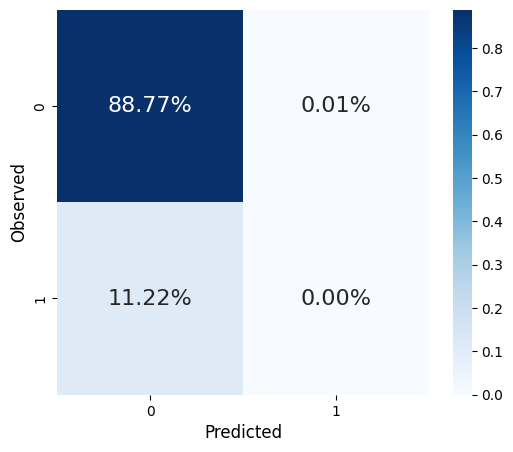

In [19]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1)
clf.fit(X_train, y_train)

_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

숫자만 봤을 때는 정확도는 매우 높은 것으로 보이지만,
Precision과 Recall은 매우 낮아 전반적인 성능은 나쁘다.

#### 1-7-1. Class Weights


모델은 기본적으로 Positive 클래스를 예측할 때 보수적 접근 방법으로 모델을 생성하기 떄문에 너무 많은 위험을 감수하지 않는다.
해결책은 Positive 클래스에 더 많은 비중을 두도록 강제하는 Hyperparameter를 활용하는 것이다.
클래스 가중치를 부여할 수 있는 방법은 여러 가지가 있지만, 그 중 하나인 `scale_pos_weight`를 활용해보자.

보통 많이 사용하는 값은 아래 수식을 통해 계산한다.

$\large{\frac{\text{number of negative samples}}{\text{number of positive samples}}}$



모델이 클래스 불균형 문제를 처리할 때, 기본 설정으로는 Positive 클래스를 예측하는 데 보수적으로 동작하게 됩니다. 이는 Negative 클래스의 데이터가 많을 경우, 단순히 대부분의 예측을 Negative로 하면 정확도가 높게 나오기 때문입니다. 그러나 이런 접근 방식은 Positive 클래스를 잘못 분류하는 경우가 많아질 수 있으며, 특히 Positive 클래스의 예측이 중요한 상황에서는 이런 접근 방식이 문제가 될 수 있습니다.

이러한 문제를 해결하기 위해 클래스의 불균형을 해소하는 다양한 방법이 제안되었습니다. 그 중 하나는 클래스에 가중치를 부여하는 것입니다. 여기서 언급된 `scale_pos_weight`는 그러한 하이퍼파라미터 중 하나로, 주로 XGBoost와 같은 알고리즘에서 사용됩니다.

`scale_pos_weight`는 Positive 클래스의 가중치를 조절하는 데 사용되며, 값이 클수록 모델은 Positive 클래스에 더 큰 중요도를 부여합니다. 이 하이퍼파라미터의 값을 설정하는 일반적인 방법은 Negative 샘플 수를 Positive 샘플 수로 나눈 값으로 계산하는 것입니다. 이렇게 계산된 값은 Positive 클래스의 예측에 더 큰 중요도를 부여하도록 모델을 유도합니다.

예를 들어, Negative 클래스 샘플이 1000개, Positive 클래스 샘플이 100개인 경우 `scale_pos_weight`는 \( \frac{1000}{100} = 10 \)이 됩니다. 이는 모델에 Positive 클래스를 10배 더 중요하게 여기도록 알려주는 것입니다.

이렇게 클래스의 가중치를 조절함으로써 모델이 더 균형 잡힌 예측을 하도록 도와줄 수 있습니다.

In [20]:
def_scale_pos_weight = len(y[y==0]) / len(y[y==1])
print(f"default scale pos weight: {def_scale_pos_weight:.2f}")

default scale pos weight: 7.96


이 값은 실제로 모델의 성능을 향상시키지만 여전히 상당한 수준의 오탐지가 존재한다.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train:  0.6381		Accuracy_test:   0.6086
Precision_test:  0.1638		Recall_test:     0.6064
ROC-AUC_test:    0.6458		F1_test:         0.2580		MCC_test: 0.1379


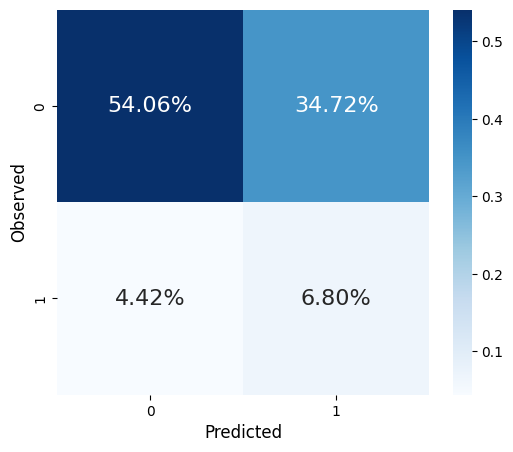

In [21]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight)
clf.fit(X_train, y_train)
_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

그리고 두 배로 만들면 오탐지가 두 배가 된다.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train:  0.3354		Accuracy_test:   0.3157
Precision_test:  0.1293		Recall_test:     0.8893
ROC-AUC_test:    0.6438		F1_test:         0.2258		MCC_test: 0.0997


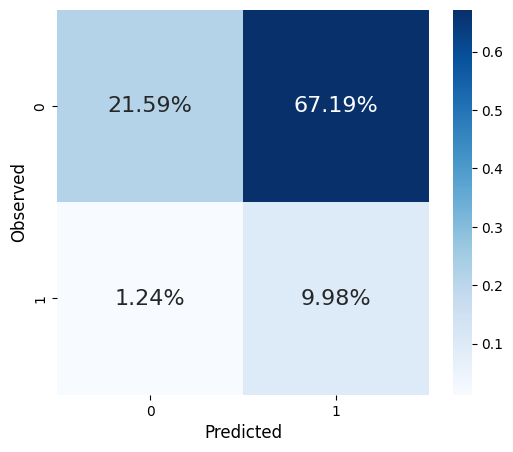

In [22]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight*2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

그리고 절반으로 줄이면 반대로 모델이 더 보수적으로 바뀐다.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train:  0.8771		Accuracy_test:   0.8617
Precision_test:  0.2232		Recall_test:     0.0937
ROC-AUC_test:    0.6485		F1_test:         0.1320		MCC_test: 0.0782


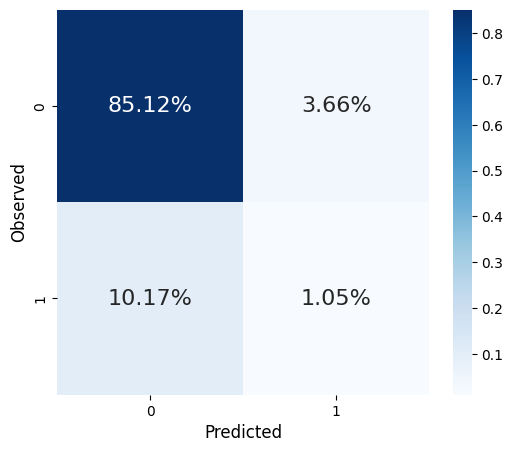

In [23]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight/2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

#### 1-7-2. Hyperparameter tuning

보수적 접근 방법은 다음과 같은 특징 때문에 실제 적용이 너무 어렵다.

- True Positive(정탐)만 Maximize
- False Positive(미탐) 최소화
- 보통은 Recall이나 Precision을 더 선호
- 미탐보다 오탐이 훨씬 더 많음

현재 모델의 결과를 보면, 거의 모든 것이 Positive 클래스에 속할 것으로 예상되는 문제가 있다.

이를 해결하기 위해 몇 가지 제약 조건을 정의해야 한다.
예를 들어, 재입원하지 않은 모든 데이터을 포함할 수 있도록 적어도 충분한 true negative(정음성)이 있어야한다.

In [24]:
min_tn = X_orig[X_orig['readmitted']=='NO'].shape[0] / X_orig.shape[0]
print(f"Patients % that never readmitted (Minimum % of True Negatives): {min_tn:.2%}")

Patients % that never readmitted (Minimum % of True Negatives): 53.91%


또한 우리는 30일이 지나서 재입원한 환자도 False Positive에 포함되도록 비율을 조정해야 한다.

In [25]:
max_fp = X_orig[X_orig['readmitted']=='>30'].shape[0] / X_orig.shape[0]
print(f"Patients % that were readmitted over 30 days later (Maximum % of False Positives): {max_fp:.2%}")

Patients % that were readmitted over 30 days later (Maximum % of False Positives): 34.93%


**Define optimization fuction**

함수에서 `scale_pos_weight`를 사용한 클래스 가중치 외에도 `max_depth`(트리 깊이를 제한하기 위해) 및 `reg_lambda` 및 `reg_alpha`를 사용한 L1/L2 정규화에 대한 최상의 하이퍼파라미터를 찾습니다. 이렇게 하면 모델이 일반화되는 데 도움이 됩니다. 목적 함수는 두 제약 조건이 충족되지 않는 경우를 제외하고 `recall`을 출력합니다. 이 경우 0을 반환합니다.

In [26]:
def optimize_lgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 11),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', def_scale_pos_weight/2, def_scale_pos_weight*2),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
    }
    if params['max_depth'] == 11:
        params['max_depth'] = -1

    clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, **params)
    clf.fit(X_train, y_train)

    metrics_dict = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test, plot=False)

    if (metrics_dict['tn%'] < min_tn) or (metrics_dict['fp%'] > max_fp):
        return 0

    return metrics_dict['recall']



1. **함수 정의**:
```python
def optimize_lgb(trial):
```
- `optimize_lgb`라는 이름의 함수를 정의합니다.
- `trial`이라는 인자를 받습니다. 이 인자는 Optuna 라이브러리에서 하이퍼파라미터 최적화를 위한 각 시도를 나타냅니다.

2. **하이퍼파라미터 설정**:
```python
params = {
    'max_depth': trial.suggest_int('max_depth', 2, 11),
    'scale_pos_weight': trial.suggest_float('scale_pos_weight', def_scale_pos_weight/2, def_scale_pos_weight*2),
    'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
}
```
- `params` 딕셔너리 안에 LightGBM 모델의 여러 하이퍼파라미터를 설정합니다.
- `trial.suggest_...` 메서드를 사용하여 각 하이퍼파라미터의 범위와 타입을 지정합니다.

3. **max_depth 값 수정**:
```python
if params['max_depth'] == 11:
    params['max_depth'] = -1
```
- 만약 `max_depth` 값이 11이라면, 그 값을 -1로 변경합니다. LightGBM에서 `max_depth` 값이 -1인 경우, 제한 없이 깊게 트리를 성장시키라는 의미입니다.

4. **모델 학습**:
```python
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, **params)
clf.fit(X_train, y_train)
```
- 설정된 하이퍼파라미터를 사용하여 LightGBM 분류기를 초기화하고 훈련 데이터로 학습시킵니다.

5. **모델 성능 평가**:
```python
metrics_dict = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test, plot=False)
```
- 앞서 주어진 `evaluate_class_mdl` 함수를 사용하여 학습된 모델의 성능을 평가하고, 그 결과를 `metrics_dict`에 저장합니다.

6. **조건 확인 및 반환**:
```python
if (metrics_dict['tn%'] < min_tn) or (metrics_dict['fp%'] > max_fp):
    return 0
```
- 만약 True Negative의 비율이 `min_tn`보다 작거나, False Positive의 비율이 `max_fp`보다 크다면, 0을 반환합니다. 이는 해당 하이퍼파라미터 설정에서 원하는 성능을 얻지 못했음을 나타냅니다.

7. **결과 반환**:
```python
return metrics_dict['recall']
```
- 최종적으로, `recall` 값을 반환합니다. 이 값은 Optuna 라이브러리가 하이퍼파라미터를 최적화하는 데 사용합니다.

함수의 주요 목적은 주어진 하이퍼파라미터 설정에서의 모델 성능을 평가하고, 그 성능을 기반으로 최적의 하이퍼파라미터를 찾는 것입니다. Optuna와 같은 라이브러리는 이 함수를 여러 번 호출하며 다양한 하이퍼파라미터 조합을 시도하여 최적의 값을 찾습니다.

**Run optimization trials**

`optuna`로 100번의 시도를 실행하는 데 몇 분 정도 걸린다.

In [27]:
%%time
opt_study = optuna.create_study(direction='maximize')
opt_study.optimize(optimize_lgb, n_trials=100)

[I 2023-10-05 11:27:00,690] A new study created in memory with name: no-name-82fcbe2d-7449-4fa0-aa7e-b720e9f5168e


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-10-05 11:27:01,215] Trial 0 finished with value: 0.09751824817518248 and parameters: {'max_depth': 3, 'scale_pos_weight': 4.037730748437467, 'reg_lambda': 0.16571711075795326, 'reg_alpha': 0.6382754778054095}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:27:15,325] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 9.699172539011656, 'reg_lambda': 0.05122315226243085, 'reg_alpha': 1.9107877852972264e-06}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:27:18,181] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 10, 'scale_pos_weight': 8.156954586051265, 'reg_lambda': 1.939392014653838, 'reg_alpha': 7.463297206200943e-05}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScor

[I 2023-10-05 11:27:21,525] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 11.645447091716232, 'reg_lambda': 0.0007270965011432846, 'reg_alpha': 4.848180626946203}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:27:23,562] Trial 4 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 12.331647333334, 'reg_lambda': 0.04162828822980844, 'reg_alpha': 1.8393478416953896e-07}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:27:25,109] Trial 5 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 12.142390220774093, 'reg_lambda': 0.34056871582220816, 'reg_alpha': 0.0915914442698741}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.429259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:27:31,317] Trial 6 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 13.292597189538832, 'reg_lambda': 0.028421554281196876, 'reg_alpha': 0.001103328054307927}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.435964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:27:33,726] Trial 7 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.534013887611298, 'reg_lambda': 0.00031443349850151896, 'reg_alpha': 6.279439035174334}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-10-05 11:27:34,889] Trial 8 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 9.698376368870811, 'reg_lambda': 4.15471388914247, 'reg_alpha': 0.028355693140615586}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-10-05 11:27:35,815] Trial 9 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 10.653320602507506, 'reg_lambda': 1.6943895071859453e-06, 'reg_alpha': 0.00013832919126282437}. Best is trial 0 with value: 0.09751824817518248.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-10-05 11:27:36,798] Trial 10 finished with value: 0.10510948905109489 and parameters: {'max_depth': 4, 'scale_pos_weight': 4.059170056503502, 'reg_lambda': 3.5289278443345755e-08, 'reg_alpha': 1.1121412040214186e-08}. Best is trial 10 with value: 0.10510948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-10-05 11:27:37,586] Trial 11 finished with value: 0.12554744525547445 and parameters: {'max_depth': 4, 'scale_pos_weight': 4.23864154806896, 'reg_lambda': 5.8323560291254514e-08, 'reg_alpha': 1.0794079992299079e-08}. Best is trial 11 with value: 0.12554744525547445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-10-05 11:27:38,594] Trial 12 finished with value: 0.10744525547445255 and parameters: {'max_depth': 4, 'scale_pos_weight': 4.0919059667506215, 'reg_lambda': 1.3970560437444778e-08, 'reg_alpha': 1.0965020064572841e-08}. Best is trial 11 with value: 0.12554744525547445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-10-05 11:27:39,320] Trial 13 finished with value: 0.4385401459854015 and parameters: {'max_depth': 4, 'scale_pos_weight': 6.220629762434593, 'reg_lambda': 1.892406881413022e-08, 'reg_alpha': 1.3416261437459931e-08}. Best is trial 13 with value: 0.4385401459854015.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-10-05 11:27:41,176] Trial 14 finished with value: 0.4566423357664234 and parameters: {'max_depth': 4, 'scale_pos_weight': 6.375586822444624, 'reg_lambda': 3.0673287443605303e-07, 'reg_alpha': 5.009129046811768e-07}. Best is trial 14 with value: 0.4566423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:27:43,794] Trial 15 finished with value: 0.46364963503649637 and parameters: {'max_depth': 5, 'scale_pos_weight': 6.469965278304785, 'reg_lambda': 7.401528901590474e-07, 'reg_alpha': 1.2727826713875274e-06}. Best is trial 15 with value: 0.46364963503649637.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.389183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:01,225] Trial 16 finished with value: 0.5640875912408759 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.307624680746655, 'reg_lambda': 1.0292557457033168e-06, 'reg_alpha': 3.2575111060991744e-06}. Best is trial 16 with value: 0.5640875912408759.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:05,474] Trial 17 finished with value: 0.6014598540145986 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.841262012300659, 'reg_lambda': 2.5855468813046724e-06, 'reg_alpha': 1.7707426346265873e-05}. Best is trial 17 with value: 0.6014598540145986.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2023-10-05 11:28:10,851] Trial 18 finished with value: 0.0 and parameters: {'max_depth': 11, 'scale_pos_weight': 8.408920053311398, 'reg_lambda': 6.4408571135575105e-06, 'reg_alpha': 1.4063738952269442e-05}. Best is trial 17 with value: 0.6014598540145986.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:11,835] Trial 19 finished with value: 0.6151824817518248 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.942709355020664, 'reg_lambda': 1.2051187372043073e-05, 'reg_alpha': 0.0010862587992789823}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:12,694] Trial 20 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 15.066205064209118, 'reg_lambda': 5.8489749541769955e-05, 'reg_alpha': 0.0006517050579415423}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:17,019] Trial 21 finished with value: 0.6026277372262774 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.831511253746724, 'reg_lambda': 1.0483693051038353e-05, 'reg_alpha': 1.604414162044385e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:17,811] Trial 22 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.295854800756903, 'reg_lambda': 1.2045162390229038e-05, 'reg_alpha': 2.9661060014084657e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:18,723] Trial 23 finished with value: 0.5769343065693431 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.4474149595748065, 'reg_lambda': 1.6366888980632823e-05, 'reg_alpha': 0.00027598640428552583}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accur

[I 2023-10-05 11:28:22,430] Trial 24 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 8.887137062103081, 'reg_lambda': 7.2216760415085e-05, 'reg_alpha': 0.004088184451727956}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:25,147] Trial 25 finished with value: 0.32145985401459853 and parameters: {'max_depth': 10, 'scale_pos_weight': 5.553158815385148, 'reg_lambda': 2.403948400515861e-07, 'reg_alpha': 1.785728173493043e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:28:25,789] Trial 26 finished with value: 0.5865693430656934 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.574995935297245, 'reg_lambda': 3.6290140608922858e-06, 'reg_alpha': 0.0020817944941787254}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:26,450] Trial 27 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.925544923781784, 'reg_lambda': 4.075184001218967e-06, 'reg_alpha': 0.00016963759235218967}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:28:27,063] Trial 28 finished with value: 0.0 and parameters: {'max_depth': 10, 'scale_pos_weight': 10.572893733547916, 'reg_lambda': 1.4123488951221634e-07, 'reg_alpha': 0.00474844575248124}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2023-10-05 11:28:27,755] Trial 29 finished with value: 0.5272992700729927 and parameters: {'max_depth': 11, 'scale_pos_weight': 7.038387706188567, 'reg_lambda': 3.2221569355743896e-05, 'reg_alpha': 7.764469597181608e-06}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > 

[I 2023-10-05 11:28:30,543] Trial 30 finished with value: 0.29927007299270075 and parameters: {'max_depth': 9, 'scale_pos_weight': 5.400787823299804, 'reg_lambda': 0.00017743903684651737, 'reg_alpha': 0.0006550548151032271}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:31,355] Trial 31 finished with value: 0.5897810218978102 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.637192019616844, 'reg_lambda': 2.955000922754331e-06, 'reg_alpha': 5.394717712598807e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:32,136] Trial 32 finished with value: 0.5927007299270073 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.803193339804265, 'reg_lambda': 1.4995204571296191e-06, 'reg_alpha': 4.904303812137806e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further spl

[I 2023-10-05 11:28:33,058] Trial 33 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.910228885970794, 'reg_lambda': 7.499028741299263e-07, 'reg_alpha': 6.04761544636204e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:33,809] Trial 34 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.017612075477585, 'reg_lambda': 1.6018706987851693e-05, 'reg_alpha': 6.496651698566558e-06}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:34,823] Trial 35 finished with value: 0.52 and parameters: {'max_depth': 7, 'scale_pos_weight': 6.989750345621566, 'reg_lambda': 0.0010369712987597238, 'reg_alpha': 3.8199642222721216e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:35,580] Trial 36 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 8.475554425463757, 'reg_lambda': 5.86621172964372e-06, 'reg_alpha': 0.00012100435362252164}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:28:36,674] Trial 37 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.003175508591887, 'reg_lambda': 1.2550031104924206e-06, 'reg_alpha': 0.0004525108812623786}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:37,463] Trial 38 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.126789966317233, 'reg_lambda': 1.3385293199121091e-07, 'reg_alpha': 5.0218323431944475e-06}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:38,278] Trial 39 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 10.192645901646012, 'reg_lambda': 2.5633210370459107e-05, 'reg_alpha': 1.4519293753897352e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:39,189] Trial 40 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 9.53718687786007, 'reg_lambda': 0.00011972967248562631, 'reg_alpha': 1.840364537308626e-06}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:39,826] Trial 41 finished with value: 0.6008759124087591 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.738640119391567, 'reg_lambda': 3.9693492728767226e-06, 'reg_alpha': 6.27996671645015e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:40,488] Trial 42 finished with value: 0.5941605839416059 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.796735668983671, 'reg_lambda': 7.448328856340607e-06, 'reg_alpha': 0.0002333526397773638}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:41,124] Trial 43 finished with value: 0.4983941605839416 and parameters: {'max_depth': 8, 'scale_pos_weight': 6.809555040831134, 'reg_lambda': 8.306889457367686e-06, 'reg_alpha': 0.00013794815268066047}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:41,795] Trial 44 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.255307447841398, 'reg_lambda': 2.4517260517727907e-05, 'reg_alpha': 0.0003995697531073013}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2023-10-05 11:28:42,416] Trial 45 finished with value: 0.5675912408759124 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.421802379743342, 'reg_lambda': 0.000421307293980265, 'reg_alpha': 0.0017831729094243847}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:28:43,066] Trial 46 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 9.805195997895538, 'reg_lambda': 2.6146299728725983e-06, 'reg_alpha': 7.039150377699341e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:43,806] Trial 47 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.675570557161809, 'reg_lambda': 5.051807035302663e-07, 'reg_alpha': 1.860797282655763e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:46,682] Trial 48 finished with value: 0.6032116788321168 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.874952697790577, 'reg_lambda': 8.574204281745233e-06, 'reg_alpha': 0.00026804684087953953}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.790665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:53,882] Trial 49 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.290373388354595, 'reg_lambda': 3.802740339459498e-05, 'reg_alpha': 0.014336375457295325}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > 

[I 2023-10-05 11:28:54,921] Trial 50 finished with value: 0.4668613138686131 and parameters: {'max_depth': 10, 'scale_pos_weight': 6.530359826682876, 'reg_lambda': 1.8800917397134057e-06, 'reg_alpha': 0.0009889204768746796}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:56,040] Trial 51 finished with value: 0.604087591240876 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.889732860191126, 'reg_lambda': 6.4992617674492e-06, 'reg_alpha': 0.00023888518413920889}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:28:56,990] Trial 52 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.489535729296483, 'reg_lambda': 1.1008171298420585e-05, 'reg_alpha': 0.00010807355502202782}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:57,774] Trial 53 finished with value: 0.5345985401459854 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.0984556583679, 'reg_lambda': 5.994131806219794e-07, 'reg_alpha': 0.00024041848642116154}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:28:58,554] Trial 54 finished with value: 0.6143065693430657 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.963935050451064, 'reg_lambda': 3.6839175886487924e-06, 'reg_alpha': 0.00046380535603378966}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further spl

[I 2023-10-05 11:28:59,527] Trial 55 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.197577901418509, 'reg_lambda': 5.714333846776937e-05, 'reg_alpha': 0.0009727313031559678}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2023-10-05 11:29:00,386] Trial 56 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 9.311294187088716, 'reg_lambda': 1.6025393641501128e-06, 'reg_alpha': 0.00042243334910541504}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:29:01,164] Trial 57 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.760873907554956, 'reg_lambda': 1.5899057603847376e-05, 'reg_alpha': 0.002046866557695522}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:01,993] Trial 58 finished with value: 0.5696350364963504 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.3772130445988795, 'reg_lambda': 5.625091041827044e-06, 'reg_alpha': 0.00019341186846910254}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-10-05 11:29:02,605] Trial 59 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 8.036540175341214, 'reg_lambda': 3.2105106233989724e-07, 'reg_alpha': 2.778687946180007e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accur

[I 2023-10-05 11:29:03,224] Trial 60 finished with value: 0.3959124087591241 and parameters: {'max_depth': 10, 'scale_pos_weight': 6.056676629621199, 'reg_lambda': 2.8583529811515592e-06, 'reg_alpha': 1.0186268525523879e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:03,906] Trial 61 finished with value: 0.5953284671532847 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.719628915473302, 'reg_lambda': 5.2017442089423385e-06, 'reg_alpha': 9.23872791280105e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:04,568] Trial 62 finished with value: 0.5255474452554745 and parameters: {'max_depth': 9, 'scale_pos_weight': 6.992306770652998, 'reg_lambda': 1.0245708167863717e-05, 'reg_alpha': 2.290519654251944e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:29:05,247] Trial 63 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.464851132029935, 'reg_lambda': 1.0795310447479197e-06, 'reg_alpha': 4.1354422035080986e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:05,878] Trial 64 finished with value: 0.5728467153284672 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.468845719295385, 'reg_lambda': 3.5273507630390263e-06, 'reg_alpha': 3.7182675909410934e-06}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:06,508] Trial 65 finished with value: 0.4905109489051095 and parameters: {'max_depth': 8, 'scale_pos_weight': 6.675824563233904, 'reg_lambda': 1.7752992840351205e-05, 'reg_alpha': 0.00032026190017806665}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:07,156] Trial 66 finished with value: 0.6087591240875913 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.927074304547152, 'reg_lambda': 2.095487025473554e-06, 'reg_alpha': 9.479780408074706e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:07,800] Trial 67 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.018718303605649, 'reg_lambda': 1.6555305835533448e-06, 'reg_alpha': 0.0007865456248874114}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:08,418] Trial 68 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.204601014172146, 'reg_lambda': 4.2006789725935414e-05, 'reg_alpha': 0.0001443569984383095}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:29:09,050] Trial 69 finished with value: 0.5442335766423357 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.178298730065913, 'reg_lambda': 4.817559536611856e-07, 'reg_alpha': 1.1700052387562951e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:29:09,690] Trial 70 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.689876377514674, 'reg_lambda': 0.00010565416428992651, 'reg_alpha': 0.004305422071780602}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:10,374] Trial 71 finished with value: 0.588029197080292 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.672417713894081, 'reg_lambda': 4.06665315213154e-06, 'reg_alpha': 3.355440726288848e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:11,053] Trial 72 finished with value: 0.6102189781021898 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.870994497954781, 'reg_lambda': 9.19704210338519e-06, 'reg_alpha': 5.957861300844765e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:11,702] Trial 73 finished with value: 0.564963503649635 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.30535814017767, 'reg_lambda': 9.5111186310283e-06, 'reg_alpha': 8.700402186876184e-05}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:12,385] Trial 74 finished with value: 0.49693430656934306 and parameters: {'max_depth': 6, 'scale_pos_weight': 6.764680189124384, 'reg_lambda': 8.847496053670948e-07, 'reg_alpha': 0.0005029989030601151}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:13,105] Trial 75 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.079274274865107, 'reg_lambda': 2.1955300187710053e-05, 'reg_alpha': 0.000198974636607594}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.359385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:16,115] Trial 76 finished with value: 0.6122627737226277 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.929861933718325, 'reg_lambda': 2.420584854826646e-06, 'reg_alpha': 0.0013538945361236396}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:17,564] Trial 77 finished with value: 0.6125547445255475 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.938311059470898, 'reg_lambda': 2.2257118190721735e-06, 'reg_alpha': 0.0012583317566893528}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:18,295] Trial 78 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.541240743736902, 'reg_lambda': 2.1796326060201714e-06, 'reg_alpha': 0.0016639437176930953}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:19,407] Trial 79 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.187802040807211, 'reg_lambda': 6.526382378302353e-06, 'reg_alpha': 0.0011933778166631386}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:20,192] Trial 80 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.24586755813676, 'reg_lambda': 9.657311541417862e-07, 'reg_alpha': 0.00059015426040165}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:21,309] Trial 81 finished with value: 0.5994160583941606 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.782405208846017, 'reg_lambda': 1.4592416755773561e-05, 'reg_alpha': 0.00034594558822916287}. Best is trial 19 with value: 0.6151824817518248.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:22,223] Trial 82 finished with value: 0.6166423357664234 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.938204999640485, 'reg_lambda': 2.578657445376336e-06, 'reg_alpha': 0.0027470826964916674}. Best is trial 82 with value: 0.6166423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further spl

[I 2023-10-05 11:29:23,213] Trial 83 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.815730394882372, 'reg_lambda': 2.1154874878397687e-06, 'reg_alpha': 0.002882761249011733}. Best is trial 82 with value: 0.6166423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:23,849] Trial 84 finished with value: 0.5716788321167883 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.457385263600009, 'reg_lambda': 6.002900906090674e-06, 'reg_alpha': 0.001173956952952201}. Best is trial 82 with value: 0.6166423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:24,498] Trial 85 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.107081129817718, 'reg_lambda': 1.146345417224634e-06, 'reg_alpha': 0.007518525968472268}. Best is trial 82 with value: 0.6166423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:25,180] Trial 86 finished with value: 0.5471532846715328 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.178803656980765, 'reg_lambda': 3.1789950222553215e-06, 'reg_alpha': 0.0026064200723972435}. Best is trial 82 with value: 0.6166423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:25,863] Trial 87 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.397619311767734, 'reg_lambda': 2.763188421556243e-05, 'reg_alpha': 0.0007194986044927861}. Best is trial 82 with value: 0.6166423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:26,527] Trial 88 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 9.486879814530306, 'reg_lambda': 9.48134468955914e-06, 'reg_alpha': 0.0002607801552129399}. Best is trial 82 with value: 0.6166423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:27,206] Trial 89 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.920705446174005, 'reg_lambda': 6.00972553383303e-07, 'reg_alpha': 0.0013216336062419015}. Best is trial 82 with value: 0.6166423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:27,880] Trial 90 finished with value: 0.5924087591240876 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.649853283345642, 'reg_lambda': 1.5620914923853815e-06, 'reg_alpha': 0.006751436511841855}. Best is trial 82 with value: 0.6166423357664234.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:28,545] Trial 91 finished with value: 0.621897810218978 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.945231349358591, 'reg_lambda': 1.0055152744702006e-05, 'reg_alpha': 0.0006296573122994357}. Best is trial 91 with value: 0.621897810218978.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:29,197] Trial 92 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.710019298655316, 'reg_lambda': 4.6231367162552005e-06, 'reg_alpha': 0.000841167944103312}. Best is trial 91 with value: 0.621897810218978.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:29,872] Trial 93 finished with value: 0.5249635036496351 and parameters: {'max_depth': 8, 'scale_pos_weight': 6.958069396136455, 'reg_lambda': 2.558149132700571e-06, 'reg_alpha': 0.0004923942680406039}. Best is trial 91 with value: 0.621897810218978.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:30,545] Trial 94 finished with value: 0.6072992700729927 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.850951825319938, 'reg_lambda': 7.670549826237822e-06, 'reg_alpha': 0.0027276300270646305}. Best is trial 91 with value: 0.621897810218978.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:31,189] Trial 95 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.329314879239545, 'reg_lambda': 1.53080736917321e-05, 'reg_alpha': 0.0020178798045993947}. Best is trial 91 with value: 0.621897810218978.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, num

[I 2023-10-05 11:29:31,866] Trial 96 finished with value: 0.5713868613138686 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.4575283038915625, 'reg_lambda': 4.134298279869505e-06, 'reg_alpha': 0.002871278975897992}. Best is trial 91 with value: 0.621897810218978.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:32,508] Trial 97 finished with value: 0.6134306569343065 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.991994181002242, 'reg_lambda': 1.3034920673210954e-06, 'reg_alpha': 0.0014880285699774658}. Best is trial 91 with value: 0.621897810218978.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2023-10-05 11:29:33,196] Trial 98 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.952035280293316, 'reg_lambda': 3.1010607662559786e-07, 'reg_alpha': 0.0034780108897505815}. Best is trial 91 with value: 0.621897810218978.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start t

[I 2023-10-05 11:29:37,100] Trial 99 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.566449833330132, 'reg_lambda': 8.147537957322798e-07, 'reg_alpha': 0.0012993823118557307}. Best is trial 91 with value: 0.621897810218978.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 16min 15s, sys: 1.91 s, total: 16min 17s
Wall time: 2min 36s



해당 코드는 `optuna` 라이브러리를 사용하여 `optimize_lgb` 함수의 결과를 최적화하는 과정을 수행합니다. `optuna`는 하이퍼파라미터 최적화를 위한 Python 라이브러리입니다.

### 코드 분석:

1. **시간 측정**:
```python
%%time
```
- `%%time`은 Jupyter 노트북의 매직 명령어로, 해당 셀의 실행 시간을 측정합니다.

2. **Optuna 스터디 생성**:
```python
opt_study = optuna.create_study(direction='maximize')
```
- `optuna.create_study` 함수를 사용하여 새로운 최적화 스터디를 생성합니다.
- `direction='maximize'`는 최적화의 목표가 최대화임을 나타냅니다. 즉, `optimize_lgb` 함수의 반환값을 최대로 만드는 하이퍼파라미터 조합을 찾는 것이 목표입니다.

3. **최적화 시작**:
```python
opt_study.optimize(optimize_lgb, n_trials=100)
```
- `opt_study.optimize` 함수를 사용하여 `optimize_lgb` 함수를 대상으로 최적화를 시작합니다.
- `n_trials=100`은 총 100번의 시도(trial)를 통해 최적의 하이퍼파라미터를 찾는다는 의미입니다. 각 시도마다 `optimize_lgb` 함수는 다른 하이퍼파라미터 조합으로 호출되며, 그 결과를 바탕으로 최적의 조합을 탐색합니다.

### 결론:

이 코드는 `optuna`를 사용하여 `optimize_lgb` 함수가 반환하는 값을 최대로 하는 하이퍼파라미터 조합을 찾는 과정을 수행합니다. 최적화 과정은 총 100번의 시도를 통해 이루어지며, 각 시도의 실행 시간을 `%%time`을 통해 측정합니다.

`study`가 끝나면 다음과 같이 최상의 결과를 얻을 수 있는 `model hyperparameter`를 출력할 수 있다.

In [28]:
best_params = opt_study.best_params
print(best_params)

{'max_depth': 8, 'scale_pos_weight': 7.945231349358591, 'reg_lambda': 1.0055152744702006e-05, 'reg_alpha': 0.0006296573122994357}


#### 1-7-3 Train Tuned Model

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

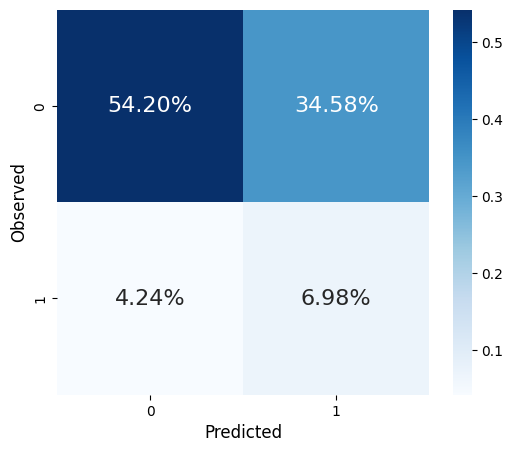

In [29]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1,\
                         **best_params)
clf.fit(X_train, y_train)

_, y_prob, y_pred = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

# **🥈Session 2**  
**┗ Error analysis**  
---

## 2) Error Analysis 소개

### 2-1. 현재까지의 결과가 최선일까?

`Confusion Matrix`를 자세히 살펴보면 `False Positive`보다 `True Positive`가 60% 더 많지만 `False Positive`가 결과적으로 더 심각한 비용을 발생시킨다.
그러나 우리가 설정한 제약으로 인해 `True Positive`의 절반 이상이 결국 재입원으로 분류될 것다. (30일 이상 지난 환자도 재분류하는 제약)

In [30]:
X_orig_test['readmitted'].value_counts()

NO     16461
>30    10644
<30     3425
Name: readmitted, dtype: int64

대부분의 모델 목표가 30일 이상 재입원을 예상하므로 긍정적인 클래스가 이 그룹을 독점적으로 나타낸다.
30일 이상 재입원 하지 않은 것에 대한 `False Positive` 오분류는 `NO` 에 대한 오분류만큼 나쁘지 않다.
그렇다면 30일 이후 재입원에 대한 오탐지 비율은 얼마일까요?

In [31]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred})
preds_df[(preds_df.y_true==0) & (preds_df.y_pred==1)].value_counts(normalize=True)

readmitted  y_true  y_pred
NO          0       1         0.503836
>30         0       1         0.496164
dtype: float64


### 코드 분석:

1. **데이터프레임 생성**:
```python
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],
                         'y_true':y_test.astype(int),
                         'y_pred':y_pred})
```
- 새로운 `preds_df` 데이터프레임을 생성합니다.
- 이 데이터프레임에는 3개의 열이 포함됩니다:
    - `readmitted`: `X_orig_test` 데이터프레임에서 `readmitted` 열의 값을 가져옵니다.
    - `y_true`: 실제 테스트 데이터의 라벨 값을 정수로 변환하여 저장합니다.
    - `y_pred`: 모델로부터 얻은 예측값을 저장합니다.

2. **조건에 맞는 데이터 필터링**:
```python
preds_df[(preds_df.y_true==0) & (preds_df.y_pred==1)]
```
- `preds_df`에서 실제 값(`y_true`)이 0이고 예측값(`y_pred`)이 1인 행만 선택합니다. 이는 모델이 Negative(0)로 분류해야 하는 샘플을 Positive(1)로 잘못 예측한 경우를 나타냅니다.

3. **값의 빈도 계산**:
```python
.value_counts(normalize=True)
```
- 선택된 행의 각 값의 빈도를 계산합니다.
- `normalize=True` 옵션은 결과를 전체 행의 수로 나눠 백분율로 반환하도록 합니다.

### 결론:

이 코드는 주어진 예측 결과와 실제 라벨을 바탕으로 모델이 Negative 클래스를 Positive로 잘못 분류한 경우의 빈도를 백분율로 계산하고 출력합니다. 이는 모델의 False Positive 비율을 파악하는 데 도움이 됩니다.

실제로 오탐지의 거의 절반(전체 테스트 샘플의 34.72%)이 결국 재입원하였으므로 사전 예방 조치를 취하는 것이 나쁜 것이 아니라고 판단된다.
우리가 고려해야 할 잘못된 결과는 나머지 절반에 대한 부분이다.

### 2-2. Error를 주제 그룹으로 나눠보자

#### 2-2-1. Error를 그룹별로 비교해보기 위해 함수를 하나 만들어보자

In [32]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc, fnr, fpr = np.nan, np.nan, np.nan
    if len(np.unique(s.y_true)) == 2:
        roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
        tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
        fnr = (fn/(tp+fn)) * 100
        fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),\
                 index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl, y_true, y_prob, y_pred, orig_df, group_col, exclude_groups=None):

    print(f"Error breakdown for group '{group_col}'")

    predict_df = pd.DataFrame({group_col: orig_df[group_col].tolist(),\
                              'y_true': y_true,
                              'y_pred': y_pred,
                              'y_prob': y_prob}, index=y_true.index)
    if exclude_groups is not None:
        predict_df = predict_df[~predict_df[group_col].isin(exclude_groups)]

    group_metrics_df = predict_df.groupby([group_col]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc']).\
            highlight_min(subset=['fnr','fpr'])

    return html

def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2,\
                               plot=True, compare_fpr=False):

    conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
    conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)

    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,5))
        sns.heatmap(conf_matrix_1/np.sum(conf_matrix_1), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
        ax[0].set_title(group_1 + ' Confusion Matrix', fontsize=14)
        ax[0].set_xlabel('Predicted', fontsize=12)
        ax[0].set_ylabel('Observed', fontsize=12)
        sns.heatmap(conf_matrix_2/np.sum(conf_matrix_2), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
        ax[1].set_title(group_2 + ' Confusion Matrix', fontsize=14)
        ax[1].set_xlabel('Predicted', fontsize=12)
        ax[1].set_ylabel('Observed', fontsize=12)
        plt.show()



### 1. `set_header_font` 함수
```python
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]
```
- 테이블의 헤더에 대한 폰트 사이즈를 설정하는 함수입니다.
- "14pt" 크기의 폰트를 사용하도록 설정값을 반환합니다.

### 2. `metrics_by_group` 함수
```python
def metrics_by_group(s):
```
- 주어진 그룹의 데이터를 기반으로 다양한 평가 지표를 계산하는 함수입니다.

```python
accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
precision = metrics.precision_score(s.y_true, s.y_pred) * 100
recall = metrics.recall_score(s.y_true, s.y_pred) * 100
f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
```
- 정확도, 정밀도, 재현율, F1 스코어를 계산합니다.

```python
if len(np.unique(s.y_true)) == 2:
    ...
```
- 라벨 값이 2개인 경우 (이진 분류)에만 ROC-AUC, FNR, FPR을 계산합니다.

### 3. `error_breakdown_by_group` 함수
```python
def error_breakdown_by_group(mdl, y_true, y_prob, y_pred, orig_df, group_col, exclude_groups=None):
```
- 주어진 그룹별로 예측 오류를 분석하는 함수입니다.

```python
predict_df = pd.DataFrame({...})
```
- 예측 결과와 실제 라벨, 그룹 정보를 포함하는 새로운 데이터프레임을 생성합니다.

```python
if exclude_groups is not None:
    ...
```
- 제외할 그룹이 지정된 경우 해당 그룹을 데이터프레임에서 제외합니다.

```python
group_metrics_df = predict_df.groupby([group_col]).apply(metrics_by_group)
```
- 그룹별로 `metrics_by_group` 함수를 적용하여 각 그룹의 평가 지표를 계산합니다.

### 4. `compare_confusion_matrices` 함수
```python
def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2, plot=True, compare_fpr=False):
```
- 두 개의 그룹의 혼동 행렬을 비교하는 함수입니다.

```python
conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)
```
- 두 그룹에 대한 혼동 행렬을 계산합니다.

```python
if plot:
    ...
```
- `plot=True`인 경우, 두 그룹의 혼동 행렬을 히트맵으로 시각화하여 표시합니다.

### 결론:
이 코드는 주어진 데이터의 그룹별 예측 오류와 성능 지표를 분석하고 시각화하는 여러 유틸리티 함수들을 정의합니다. 각 함수는 특정 평가 지표를 계산하거나, 그룹별 예측 오류를 분석하거나, 혼동 행렬을 비교 및 시각화하는 역할을 수행합니다.

#### 2-2-2. 그룹 별 에러 분석

**몇 가지 인구통계 정보를 통한 분석 (나이)**

In [33]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='age')

Error breakdown for group 'age'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
age,,,,,,,,
Over 60 years,"20,566",57.8%,16.4%,62.6%,26.0%,62.5%,37.4%,42.8%
30-60 years,"9,201",67.7%,17.2%,60.0%,26.7%,67.6%,40.0%,31.5%
30 years or younger,763,73.3%,24.8%,73.2%,37.0%,77.1%,26.8%,26.7%


**몇 가지 인구통계 정보를 통한 분석 (성별, 성별 미상 제외)**

In [33]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='gender',\
                         exclude_groups=['Unknown/Invalid'])

`Confusion Matrix`를 양쪽에 나란히 두고 비교하면 분석할 때 편하다.

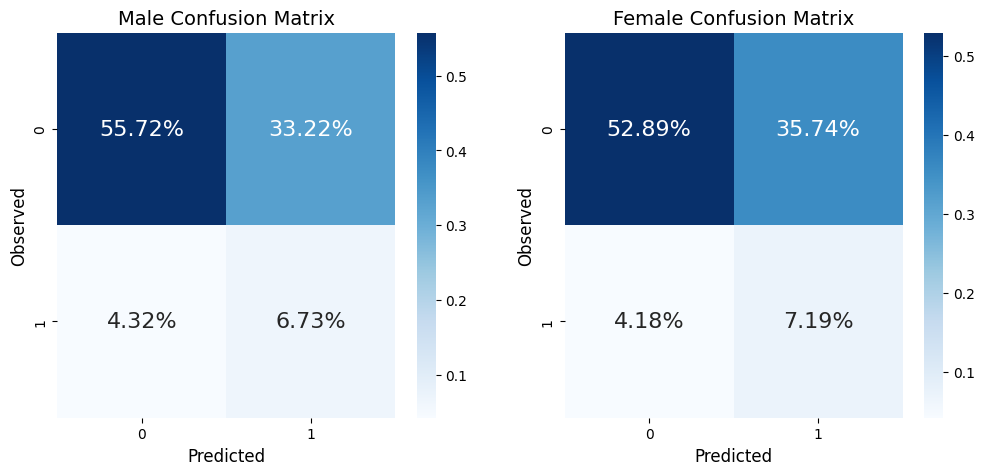

In [34]:
_ = compare_confusion_matrices(y_test[X_test['gender_Male']==1], y_pred[X_test['gender_Male']==1],\
                           y_test[X_test['gender_Female']==1], y_pred[X_test['gender_Female']==1],\
                           'Male', 'Female')

이 코드는 두 개의 혼동 행렬(confusion matrices)을 비교하는 함수 `compare_confusion_matrices`를 호출하는 것 같습니다. 특히 성별에 따른 혼동 행렬을 비교하는데 집중하고 있습니다. 코드를 한국말로 간략하게 설명하면 다음과 같습니다.

1. `y_test[X_test['gender_Male']==1]` : `y_test`에서 `X_test`의 `gender_Male` 열 값이 1인 경우만 선택합니다. 이는 `y_test`의 남성 데이터만 필터링하는 것을 의미합니다.

2. `y_pred[X_test['gender_Male']==1]` : `y_pred`에서 `X_test`의 `gender_Male` 열 값이 1인 경우만 선택합니다. 이는 `y_pred`의 남성 데이터 예측 결과만 필터링하는 것을 의미합니다.

3. `y_test[X_test['gender_Female']==1]` : `y_test`에서 `X_test`의 `gender_Female` 열 값이 1인 경우만 선택합니다. 여성 데이터만 필터링하는 것을 의미합니다.

4. `y_pred[X_test['gender_Female']==1]` : `y_pred`에서 `X_test`의 `gender_Female` 열 값이 1인 경우만 선택합니다. 여성 데이터 예측 결과만 필터링하는 것을 의미합니다.

5. `'Male'`과 `'Female'`: 함수에 전달되는 다른 두 인자로, 각각의 혼동 행렬을 구별하기 위한 레이블입니다.

결과적으로, 이 코드는 남성과 여성 데이터에 대한 실제 결과(`y_test`)와 예측 결과(`y_pred`)의 혼동 행렬을 비교하는 함수를 호출하는 것입니다. 함수의 결과나 출력은 주어진 코드에서는 나타나지 않습니다.

**몇 가지 의학적 특징을 통한 분석**

아마도 몇몇 의학적 특징은 인구 통계학적 특징보다 더 뚜렷한 차이가 있을 수도 있다.

In [35]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='admission_source_id')

Error breakdown for group 'admission_source_id'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
admission_source_id,,,,,,,,
Emergency,"17,228",58.2%,17.1%,65.7%,27.1%,64.6%,34.3%,42.8%
Referral,"9,303",65.1%,16.8%,56.6%,25.9%,64.8%,43.4%,33.9%
Other,"3,999",64.8%,15.3%,58.1%,24.2%,64.3%,41.9%,34.5%


In [36]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='had_inpatient_days')

Error breakdown for group 'had_inpatient_days'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
had_inpatient_days,,,,,,,,
False,"20,292",78.2%,14.9%,33.4%,20.6%,62.2%,66.6%,17.6%
True,"10,238",27.4%,17.6%,91.2%,29.5%,57.2%,8.8%,85.4%


꽤 명확하게 보인다..
무슨 일이 일어나고 있는지 이해하기 위해 이것을 비교해보자.

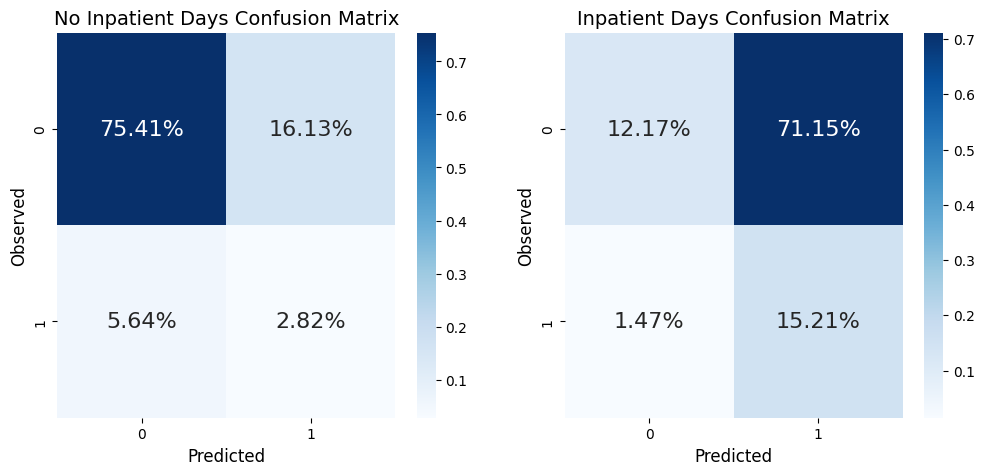

In [37]:
_ = compare_confusion_matrices(y_test[X_test['had_inpatient_days']==0], y_pred[X_test['had_inpatient_days']==0],\
                           y_test[X_test['had_inpatient_days']==1], y_pred[X_test['had_inpatient_days']==1],\
                           'No Inpatient Days', 'Inpatient Days', compare_fpr=True)

30일 이후 재입원을 포함하지 않는 하위 집합이 유사한 `Confusion Matrix`를 갖는지 보자.

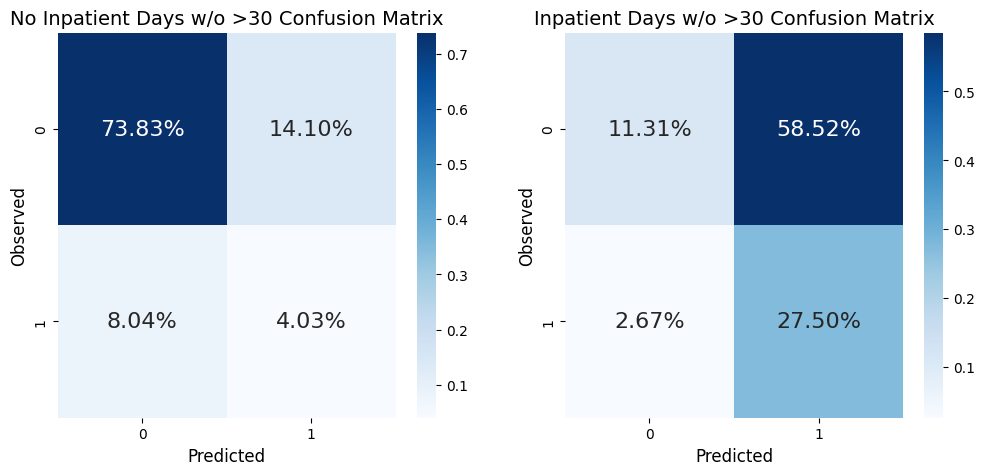

In [38]:
_ = compare_confusion_matrices(y_test[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')],\
                           y_test[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')],\
                           'No Inpatient Days w/o >30', 'Inpatient Days w/o >30', compare_fpr=True)

# 🥇Session 3 - 「주제그룹 분석」

## 3) Feature Importance and More Advanced Error Analysis

### 3-1. Sample data

---



In [40]:
X_test_sample = X_test[(X_orig_test['readmitted']!='>30')].sample(frac=0.1)
y_test_sample = y_test.loc[X_test_sample.index]

y_prob_sample = clf.predict_proba(X_test_sample)[:,1]
y_pred_sample = np.where(y_prob_sample > 0.5, 1, 0)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [41]:
X_test_sample

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
20489,5,42,1,10,9,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
953,3,60,0,10,7,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
3714,13,75,6,28,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
18373,5,41,2,20,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
50628,2,35,0,15,4,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52935,8,55,1,14,7,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
61979,3,47,0,9,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1
81860,3,45,0,14,9,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
66276,3,62,0,17,7,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1


### 3-2. SHAP values 생성하기

In [42]:
%%time
shap_explainer = shap.Explainer(clf, X_train)
shap_values = shap_explainer(X_test_sample)

CPU times: user 6.01 s, sys: 51.2 ms, total: 6.06 s
Wall time: 5.96 s


In [43]:
shap_values.values

array([[ 2.98081827e-02,  1.20458907e-02,  2.00899517e-02, ...,
        -6.84613585e-04,  1.55331527e-02,  2.06717066e-04],
       [ 1.62313231e-02,  1.93891803e-02,  1.20523889e-02, ...,
         5.80655076e-04,  1.64991535e-02,  0.00000000e+00],
       [ 1.95375707e-01, -3.29447893e-01, -5.09120049e-02, ...,
        -8.55766982e-04,  7.10284867e-03,  1.03358533e-04],
       ...,
       [-1.43794055e-02,  8.36214276e-02,  2.46219821e-02, ...,
         0.00000000e+00,  3.99471483e-02,  6.20151218e-05],
       [-2.97304562e-02,  1.55865115e-01,  3.45007320e-02, ...,
        -1.22568300e-03,  3.78038596e-02,  0.00000000e+00],
       [ 1.58042163e-02,  1.98818699e-02,  2.29181052e-02, ...,
        -1.22568300e-03,  9.28699246e-03,  2.06717066e-04]])

In [44]:
print(shap_values.values.shape)

(1989, 54)


### 3-3. Feature Importance Plots

한 축에서 SHAP 값의 절대값을 평균화하면 기능 중요도 측정값(Feature당 하나)

In [45]:
np.abs(shap_values.values).mean(axis=0)

array([7.69222382e-02, 7.45824445e-02, 4.02091879e-02, 7.96354704e-02,
       6.69774463e-02, 1.80697390e-02, 6.18604236e-04, 3.03028899e-02,
       2.73456791e-01, 5.97748245e-03, 1.14762053e-02, 1.31950035e-03,
       1.30625891e-02, 5.72591339e-03, 8.97471362e-03, 8.50680419e-03,
       9.01720819e-03, 1.04519553e-02, 0.00000000e+00, 3.38861165e-03,
       3.01405092e-03, 4.50699809e-02, 1.90934228e-01, 3.44006820e-04,
       6.09806652e-03, 2.40906252e-02, 7.67326285e-03, 2.36348687e-02,
       6.04444072e-03, 8.50561863e-03, 6.15759650e-03, 7.50836861e-03,
       4.50056433e-03, 1.42944223e-02, 4.03537771e-03, 1.49904928e-02,
       4.04563152e-02, 5.67924975e-02, 1.93549066e-03, 9.09854752e-04,
       2.80873701e-03, 9.10881911e-04, 8.33406435e-03, 7.22859013e-03,
       3.12492142e-02, 5.57127321e-03, 2.53374125e-02, 1.91871779e-02,
       8.92233234e-03, 3.80434328e-03, 1.44475828e-02, 8.37882388e-04,
       5.14795047e-02, 1.13635536e-04])

이 함수는 각 Feature의 Importance 순위 표시

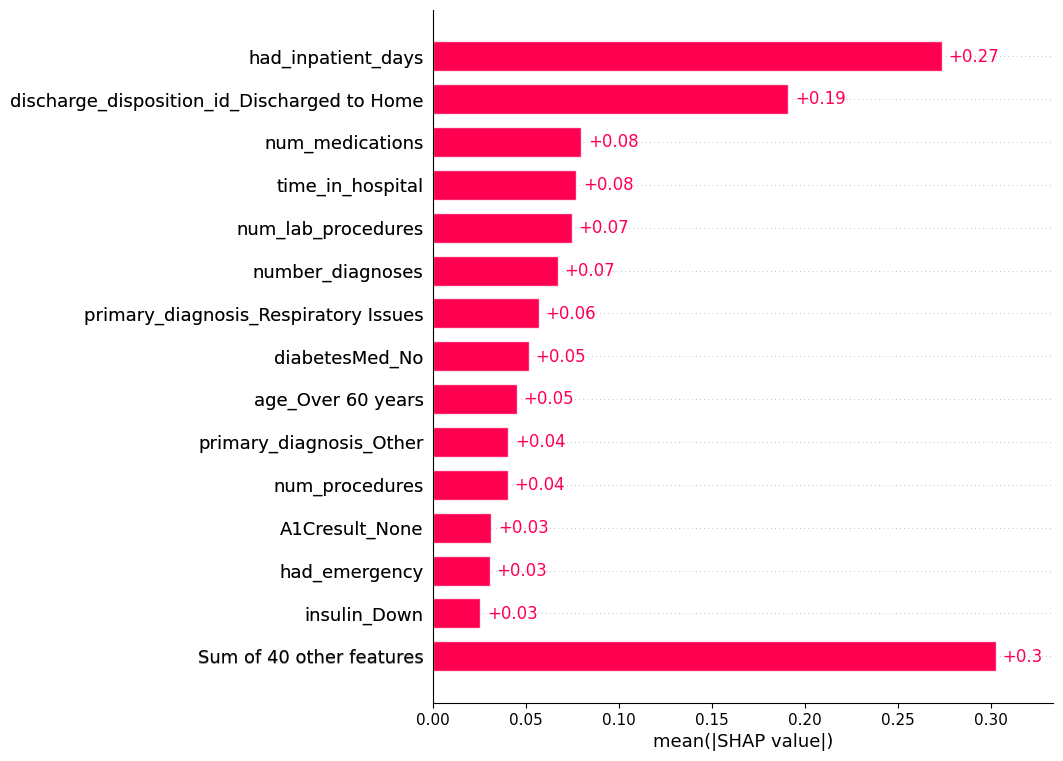

In [46]:
shap.plots.bar(shap_values, max_display=15)

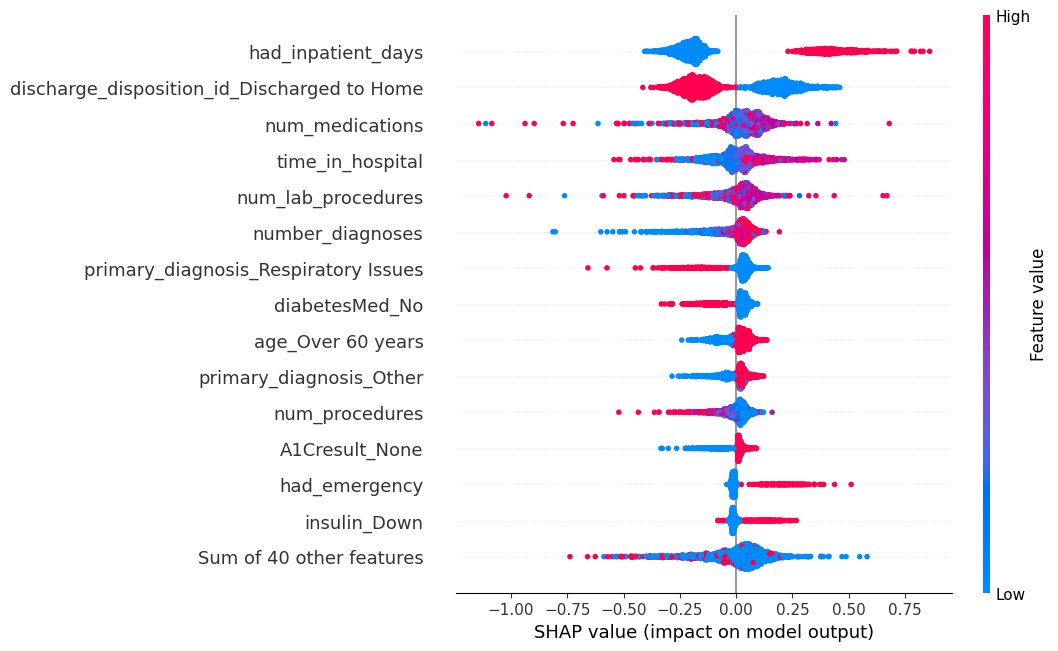

In [47]:
shap.plots.beeswarm(shap_values, max_display=15)

### 3-4. Scatter Plots

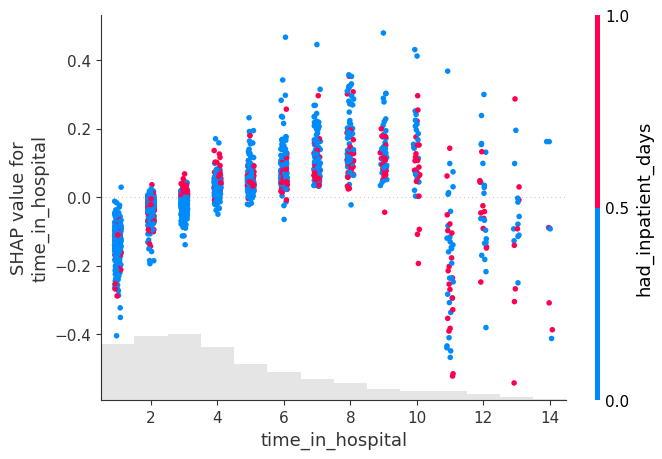

In [48]:
shap.plots.scatter(shap_values[:,"time_in_hospital"],\
                   color=shap_values[:,"had_inpatient_days"])

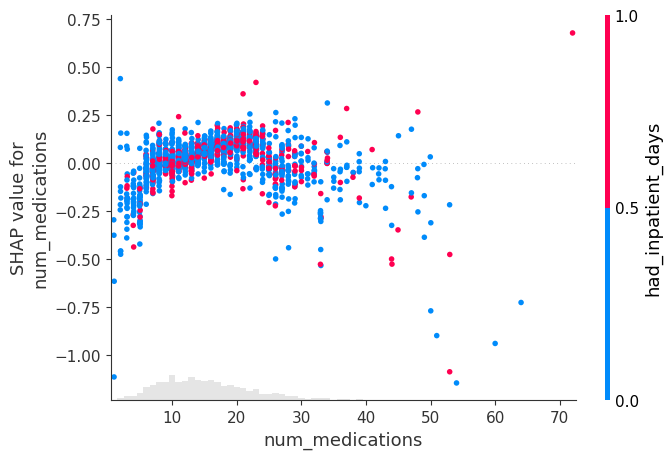

In [49]:
shap.plots.scatter(shap_values[:,"num_medications"],\
                   color=shap_values[:,"had_inpatient_days"])

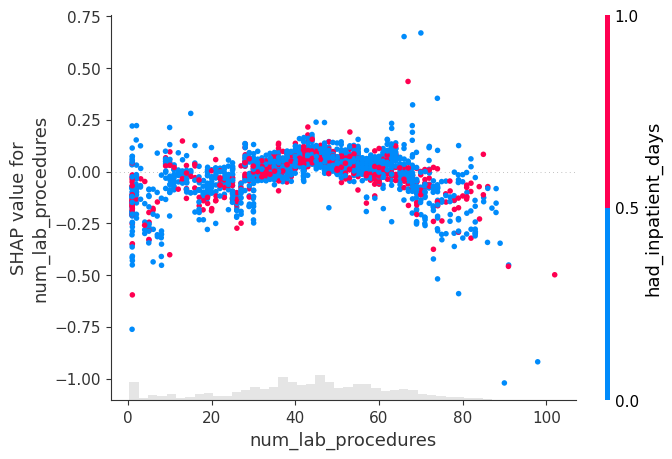

In [50]:
shap.plots.scatter(shap_values[:,"num_lab_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

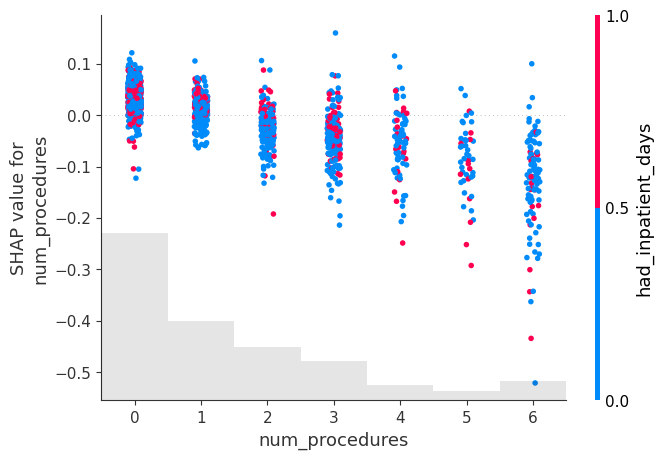

In [51]:
shap.plots.scatter(shap_values[:,"num_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

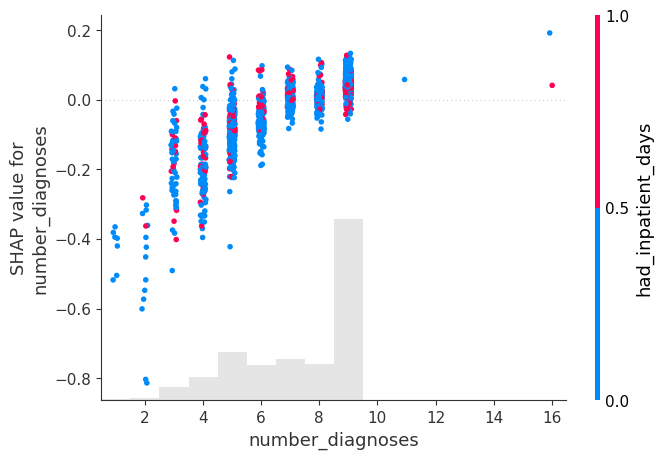

In [52]:
shap.plots.scatter(shap_values[:,"number_diagnoses"], color=shap_values[:,"had_inpatient_days"])

### 3-5. 에러를 줄이는 몇 가지 전략

#### 3-5-1. Post-processing (predictions)

이것은 일종의 편법이라고 생각할 수도 있지만 Positive 클래스를 예측하는 경우에 대한 임계값 조절하는 것은 일반적인 일이다. 임계값이 일관되게 0.5일 필요는 없다. 에러를 최소화하기 위해 확률 자체를 보정하는 경우도 있다.

In [53]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'had_inpatient_days':X_test['had_inpatient_days'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred,
                         'y_prob':y_prob})
preds_df = preds_df[(preds_df['readmitted']!='>30')]

preds_df['y_pred_new'] = np.where(preds_df.had_inpatient_days==0,\
                                  np.where(preds_df.y_prob > 0.45, 1, 0),
                                  np.where(preds_df.y_prob > 0.59, 1, 0))

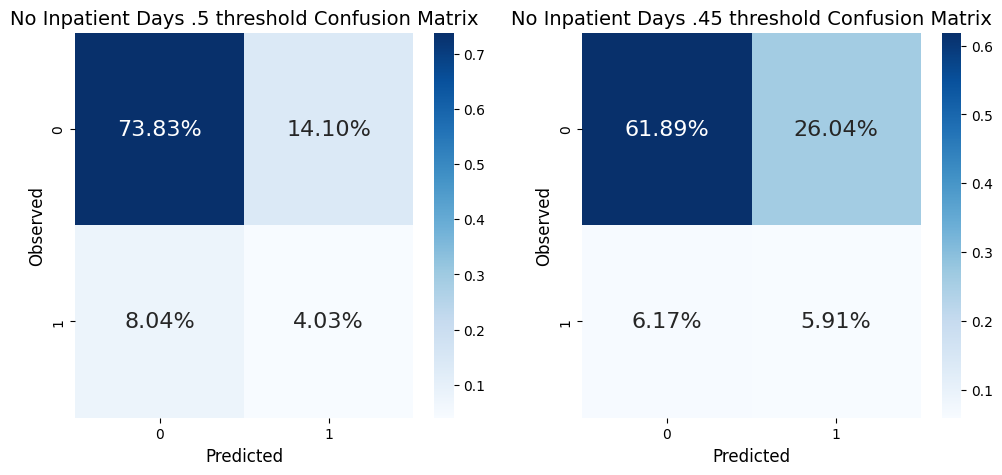

In [54]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred_new'],
                               'No Inpatient Days .5 threshold', 'No Inpatient Days .45 threshold')

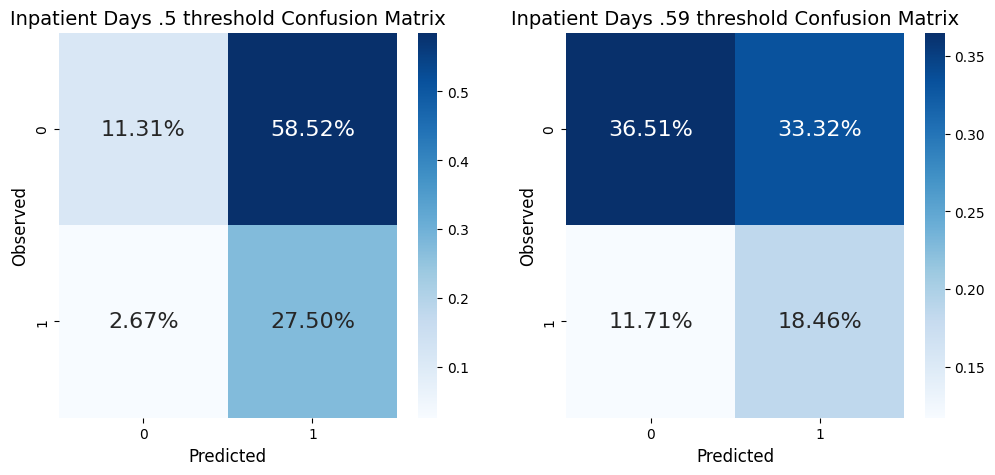

In [55]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred_new'],
                               'Inpatient Days .5 threshold', 'Inpatient Days .59 threshold')

#### 3-5-2. In-processing (model)

- `sample_weight` 혹은 다양한 `sampling` 기법을 사용하여 모델이 가장 못 맞추는 샘플에 더 집중하도록 한다.
- 코호트에 따라 `False Negative`를 다르게 패널티화하는 맞춤형 `loss function` 활용
- 대신 다중 클래스 분류 모델을 사용해보자. 아마도 `NO`와 `>30`을 분리하면 모델의 성능이 향상될 수 있다.

#### 3-5-3. Pre-processing (data)

- 도메인 전문가와 함께 에러를 검토하고 더 잘 분류하는 데 도움이 될 수 있는 새로운 Feature를 찾아보는게 좋다.
- 이전에 엔지니어링된 일부 Feature가 특징을 잘 분류할 수 있는 특성이 엔지니어링 과정에서 사라졌을 수도 있다. 예를 들어 연령은 연령 그룹에 있지만 더 작은 그룹 또는 실제 연령으로 사용한다면 오류가 더 줄어들 것입니다. (대신 연산량이 많아짐)
